In [1]:
import pickle
import json
import numpy as np

Directory with your experiments:

In [2]:
dir_with_experiments = '<insert your dir>'

In [3]:
num_classes = 45  
num_targets = 950028

## Codelength

For example, let's look at the experiment with linguistic task, layer 1. 

#### Uniform codelength

In [4]:
uniform_codelength = num_targets * np.log2(num_classes)

#### Variational codelength

In the experiment folder you will find a file with the information for each validation step. You have to use the last step.

In [5]:
report = json.load(open(dir_with_experiments + 'bayes_l1/train_report.json'))
total_code = report[-1]['kl'] + report[-1]['train_xent']

In [6]:
print("Variational codelength: {} kbits".format(round(total_code / 1024)))
print("Compression: {} ".format(round(uniform_codelength / total_code, 2)))

Variational codelength: 85 kbits
Compression: 59.76 


## Induced probe architecture

The report we used before contains also information about probe (report[-1]['bayes_masks_test'])
#### But it is not correct and do not use it!

### Look at the distributions

To decide which weights can be pruned, we follow the original paper [Bayesian compression](https://arxiv.org/abs/1705.08665). Namely, we determining the threshold for pruning with manual inspection as usually there are two well separated clusters (signal and noise).

In [7]:
import torch
import sys
sys.path.append('<insert path to the repo>/control_tasks') # insert path to the repo

import matplotlib.pyplot as plt
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [8]:
probe = torch.load(dir_with_experiments + 'bayes_l1/checkpoint/probe_199.pth') # last checkpoint

In [9]:
masks, alphas = probe.get_masks([0, 0, 0], # thresholds for pruning - do not know for now
                                return_log_alpha=True)

#### Look at distributions for each probe layer and find a threshold.

(array([  3.,   9.,  30., 133., 279., 140.,  57.,  12.,   8.,   3.,   1.,
          3.,   8.,  32.,  66.,  71.,  53.,  34.,  35.,  47.]),
 array([-8.844007  , -8.030653  , -7.2173    , -6.403947  , -5.590594  ,
        -4.7772408 , -3.9638872 , -3.1505342 , -2.3371809 , -1.5238277 ,
        -0.7104745 ,  0.10287871,  0.91623193,  1.7295852 ,  2.5429382 ,
         3.3562915 ,  4.169645  ,  4.982998  ,  5.796351  ,  6.6097045 ,
         7.4230576 ], dtype=float32),
 <a list of 20 Patch objects>)

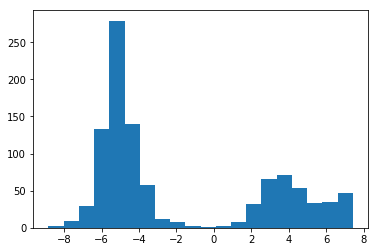

In [10]:
plt.hist(alphas[0], bins=20)

Here it looks like the clusters are separated by zero.

(array([  5.,  14.,  11.,  13.,   8.,   2.,   0.,   0.,   0.,   1.,   5.,
         34.,  88., 149., 174., 146., 126.,  82.,  76.,  66.]),
 array([-10.31048   ,  -9.453717  ,  -8.596953  ,  -7.7401905 ,
         -6.8834276 ,  -6.0266643 ,  -5.169901  ,  -4.313138  ,
         -3.4563746 ,  -2.5996115 ,  -1.7428484 ,  -0.8860852 ,
         -0.02932205,   0.8274411 ,   1.6842043 ,   2.5409675 ,
          3.3977306 ,   4.2544937 ,   5.111257  ,   5.96802   ,
          6.8247833 ], dtype=float32),
 <a list of 20 Patch objects>)

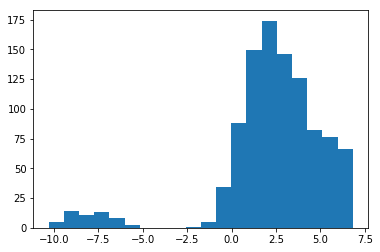

In [11]:
plt.hist(alphas[1], bins=20)

Here, by -3 (or -4, -5).

(array([  6.,  21.,   6.,   4.,   0.,   0.,   0.,   1.,  30.,  98., 131.,
        154., 149., 117.,  83.,  72.,  49.,  37.,  22.,  20.]),
 array([-9.721072  , -8.672385  , -7.623699  , -6.5750127 , -5.526326  ,
        -4.477639  , -3.428953  , -2.3802664 , -1.3315798 , -0.28289324,
         0.7657933 ,  1.8144798 ,  2.8631663 ,  3.911853  ,  4.9605393 ,
         6.009226  ,  7.057913  ,  8.106599  ,  9.155286  , 10.203972  ,
        11.252659  ], dtype=float32),
 <a list of 20 Patch objects>)

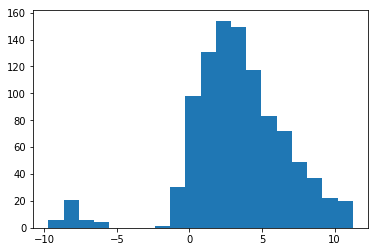

In [12]:
plt.hist(alphas[2], bins=20)

Set thresholds and eval number of neurons at each layer.

In [13]:
thesholds = [0, -3, -5]

masks, alphas = probe.get_masks(thesholds, # now we know them
                                return_log_alpha=True)

In [14]:
print("Pruned architecture: {}-{}-{}".format(sum(masks[0]), sum(masks[1]), sum(masks[2])))

Pruned architecture: 664-55-35
